In [8]:
#Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from PIL import Image

import torch
from torchsummary import summary
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import keras
import keras.backend as K
import tensorflow as tf
import os

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, Concatenate
import cv2
import numpy as np

from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
import numpy as np
import os 
from PIL import Image
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
#Làm giàu ảnh
import random
def rotate(img):
  angle = random.randint(0, 360) # Chọn một góc xoay ngẫu nhiên từ 0 đến 360 độ
  (h, w) = img.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(img, M, (w, h))
  return rotated
def flip(rotated):
  flip_code = random.randint(-1, 1) # Chọn một trục ngẫu nhiên để lật ảnh
  flipped = cv2.flip(rotated, flip_code)
  return flipped

In [5]:
file_path_no_VietNam = 'D:\AI\Map\[AI Naver] Map Detect-20230509T013528Z-001\[AI Naver] Map Detect\datanovietnam'
file_path_have_VietNam = 'D:\AI\Map\[AI Naver] Map Detect-20230509T013528Z-001\[AI Naver] Map Detect\dataVietNam'
img_name_have_VN = os.listdir(file_path_have_VietNam)
img_name_no_VN = os.listdir(file_path_no_VietNam)

In [9]:
images = []
labels = []
#Read and add to list
for name in img_name_have_VN:
  img_path = os.path.join(file_path_have_VietNam, name)
  img = cv2.imread(img_path)
  if img is not None:
    img = cv2.resize(img,(224,224))
    rotated = rotate(img)
    flipped = flip(rotated) 
    images.append(img)
    labels.append(1)
    images.append(rotated)
    labels.append(1)
    images.append(flipped)
    labels.append(1)


for name in img_name_no_VN:
  img_path = os.path.join(file_path_no_VietNam, name)
  img = cv2.imread(img_path)
  if img is not None:
    img = cv2.resize(img,(224,224))
    images.append(img)
    labels.append(0)

"""file_path_have_VietNam = '/content/gdrive/MyDrive/Map Image/Data no VietNam/notmapvn'
for name in img_name_no_VN:
  img_path = os.path.join(file_path_no_VietNam, name)
  img = cv2.imread(img_path)
  if img is not None:
    img = cv2.resize(img,(224,224))
    images.append(img)
    labels.append(0)"""
# Convert to np
images = np.array(images)
labels = np.array(labels)
# Data shape
print(images.shape)
print(labels.shape)

(4188, 224, 224, 3)
(4188,)


In [10]:
based_model = vgg16.VGG16(weights = 'imagenet',
                    include_top = False,
                    input_shape = (224, 224, 3))

# Freeze layers, not training these layers
for layer in based_model.layers:
    layer.trainable = False 

# Summary model 
based_model.summary()

58889256/58889256 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state = 42)
# Reshape
X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 3)
# Chia cho 255
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
# 
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, monitor='loss')

In [14]:
def layer_added(output_based_network, num_classes):
  x = output_based_network
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(2, activation='softmax')(x)

  return x

output_based_network = based_model.output 
output_layer = layer_added(output_based_network, 2)
model = Model(based_model.input, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# compile model 
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['acc'])    

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=32, 
          epochs=10, callbacks = [es])

Epoch 1/10
105/105 [==============================] - 313s 3s/step - loss: 0.7828 - acc: 0.9278 - val_loss: 0.1164 - val_acc: 0.9761
Epoch 2/10
105/105 [==============================] - 329s 3s/step - loss: 0.1093 - acc: 0.9755 - val_loss: 0.1731 - val_acc: 0.9702
Epoch 3/10
105/105 [==============================] - 307s 3s/step - loss: 0.0354 - acc: 0.9916 - val_loss: 0.0808 - val_acc: 0.9833
Epoch 4/10
105/105 [==============================] - 311s 3s/step - loss: 0.0054 - acc: 0.9979 - val_loss: 0.0883 - val_acc: 0.9785
Epoch 5/10
105/105 [==============================] - 307s 3s/step - loss: 0.0061 - acc: 0.9976 - val_loss: 0.0929 - val_acc: 0.9809
Epoch 6/10
105/105 [==============================] - 307s 3s/step - loss: 0.0059 - acc: 0.9976 - val_loss: 0.0968 - val_acc: 0.9809
Epoch 7/10
105/105 [==============================] - 306s 3s/step - loss: 0.0091 - acc: 0.9979 - val_loss: 0.1277 - val_acc: 0.9785
Epoch 8/10
105/105 [==============================] - 307s 3s/step - 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


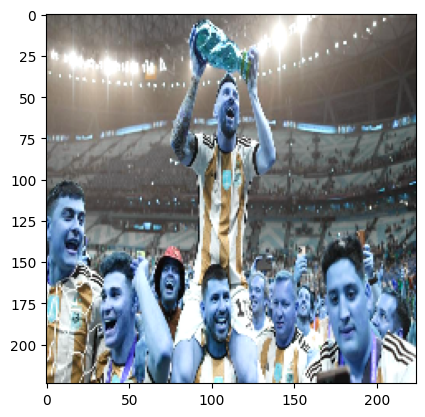

In [34]:
img_test = cv2.imread('D:\AI\Map\Lionel Messi Argentina trophy 121822.jpg')
if img_test is not None:
  img_test = cv2.resize(img_test, (224, 224))
  img_float = img_test.astype('float32')/225
  plt.imshow(img_float)
  plt.show()

In [23]:
y_hat = model.predict(np.expand_dims(img_test, axis=0))
y_label = np.argmax(y_hat, axis = 1)

print(y_label)
if y_label < 0.5:
  print("This image does not contain a Viet Nam map inside")
else: print("This image contains a Viet Nam map inside")


1/1 [==============================] - 0s 371ms/step
[0]
This image does not contain a Viet Nam map inside


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


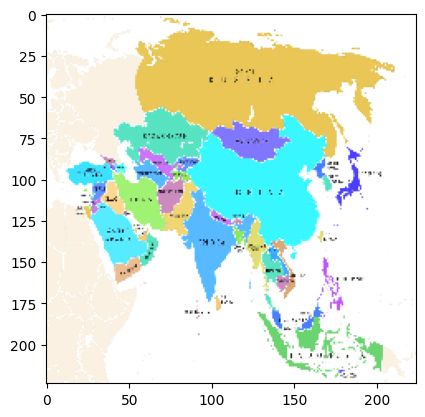

In [45]:
img_test = cv2.imread('D:\AI\Map\ASIAN.jpg')
if img_test is not None:
  img_test = cv2.resize(img_test, (224, 224))
  img_float = img_test.astype('float32')/225
  plt.imshow(img_float)
  plt.show()


In [46]:
y_hat = model.predict(np.expand_dims(img_test, axis=0))
y_label = np.argmax(y_hat, axis = 1)

print(y_label)
if y_label < 0.5:
  print("This image does not contain a Viet Nam map inside")
else: print("This image contains a Viet Nam map inside")

1/1 [==============================] - 0s 124ms/step
[0]
This image does not contain a Viet Nam map inside


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


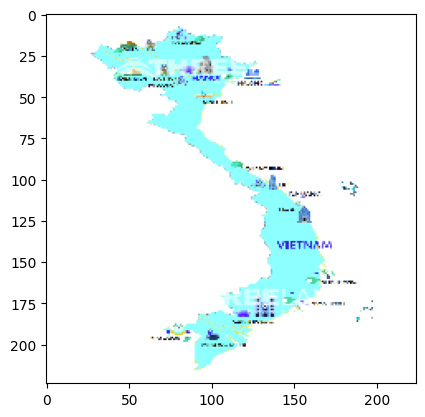

In [38]:
img_test = cv2.imread('D:\AI\Map\hihi.png')
if img_test is not None:
  img_test = cv2.resize(img_test, (224, 224))
  img_float = img_test.astype('float32')/225
  plt.imshow(img_float)
  plt.show()

In [39]:
y_hat = model.predict(np.expand_dims(img_test, axis=0))
y_label = np.argmax(y_hat, axis = 1)

print(y_label)
if y_label < 0.5:
  print("This image does not contain a Viet Nam map inside")
else: print("This image contains a Viet Nam map inside")


1/1 [==============================] - 0s 126ms/step
[1]
This image contains a Viet Nam map inside


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


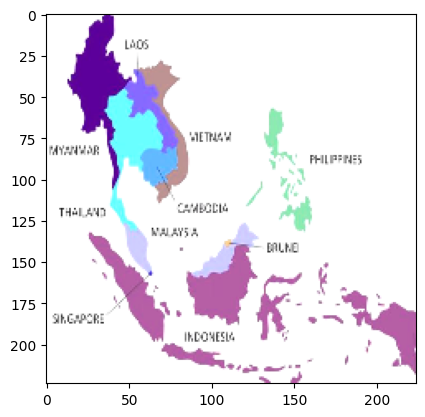

In [43]:
img_test = cv2.imread('D:\AI\Map\ASEAN.jpg')
if img_test is not None:
  img_test = cv2.resize(img_test, (224, 224))
  img_float = img_test.astype('float32')/225
  plt.imshow(img_float)
  plt.show()

In [44]:
y_hat = model.predict(np.expand_dims(img_test, axis=0))
y_label = np.argmax(y_hat, axis = 1)

print(y_label)
if y_label < 0.5:
  print("This image does not contain a Viet Nam map inside")
else: print("This image contains a Viet Nam map inside")

1/1 [==============================] - 0s 120ms/step
[1]
This image contains a Viet Nam map inside
